In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random


from termcolor import colored

from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Model
# --------------------------------------------------------------------
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics

In [2]:
def metricas(validacion, prediccion, churm):
    
    print("Exactitud: ", metrics.accuracy_score(validacion, prediccion))
    print("Kappa: ", metrics.cohen_kappa_score(validacion, prediccion))
    
    print(colored('Predicciones de los registros mineros', attrs=['bold']))
    
    print("Precisión: ",  metrics.precision_score(validacion, prediccion, labels=[1], average='macro'))
    print("Recall: ",  metrics.recall_score(validacion, prediccion, labels=[1], average='macro'))
    
    VP = np.sum(churm[1:2,1:2])
    FN = np.sum(churm[1,0:1])
    specificity = VP/(VP+FN)
    
    print("Especificidad : ", specificity)
    print("F1-score      : ", metrics.f1_score(validacion, prediccion, labels=[1], average='macro'))
    
    
    print(colored('Predicciones de los registros no mineros', attrs=['bold']))
    
    print("Precisión: ",  metrics.precision_score(validacion, prediccion, labels=[0], average='macro'))
    print("Recall: ",  metrics.recall_score(validacion, prediccion, labels=[0], average='macro'))
    
    VP = np.sum(churm[0:1,0:1])
    FN = np.sum(churm[0,1:2])
    specificity = VP/(VP+FN)
    
    print("Especificidad : ", specificity)
    print("F1-score      : ", metrics.f1_score(validacion, prediccion, labels=[0], average='macro'))

In [3]:
def matriz_confusion(validacion, prediccion, cmap):
    print(colored('Matriz de confusión', attrs=['bold']))
    churm = metrics.confusion_matrix(validacion, prediccion)
    plt.imshow(churm, cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Not_mine','Mine'])
    plt.yticks(tick_marks, ['Not_mine','Mine'])
    return churm

# Load Data

In [4]:
dataA = pd.read_csv('./data_identificada.csv').drop(['index','Name','Second_Protocol', 'Third_Protocol'], axis = 1)
dataA.head(1)

,Netflows,First_Protocol,p1_d,p2_d,p3_d,duration,max_d,min_d,#packets,Avg_bps,...,second_dp,third_dp,p1_ip,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib,Type,Cryptocurrency
0,400,TCP,0.0,0.0,9.04175,4287.992,65.519,0.0,6750,360512,...,53.0,80.0,1.0,1.0,5.5,32.0,33.0,873.0,not_mine,Does not have


# Preprocesamiento

### Imputación de valores ausentes

In [5]:
punter = pd.concat([dataA['second_sp'],dataA['second_dp'],dataA['third_sp'],dataA['third_dp']],axis=1)
imputer = SimpleImputer(missing_values = np.nan, strategy = "median")
values = imputer.fit_transform(punter)

In [6]:
punter = pd.DataFrame(values, columns = punter.columns)
dataA['second_sp'] = punter['second_sp']
dataA['second_dp'] = punter['second_dp']
dataA['third_sp'] = punter['third_sp']
dataA['third_dp'] = punter['third_dp']

### OneHotEncoder

In [7]:
data_categoric = dataA[dataA.select_dtypes(include = ['object']).columns.to_list()]
one_hot = OneHotEncoder()
one_hot.fit_transform(data_categoric)

<4733x12 sparse matrix of type '<class 'numpy.float64'>'
	with 14199 stored elements in Compressed Sparse Row format>

In [8]:
data_dummy = pd.get_dummies(data_categoric)
data_dummy.head(2)

,First_Protocol_ICMP,First_Protocol_ICMP6,First_Protocol_TCP,First_Protocol_UDP,Type_mine,Type_not_mine,Cryptocurrency_Bitcash,Cryptocurrency_Bitcoin,Cryptocurrency_Does not have,Cryptocurrency_Etherium,Cryptocurrency_Litecoin,Cryptocurrency_Monero
0,0,0,1,0,0,1,0,0,1,0,0,0
1,0,0,0,1,0,1,0,0,1,0,0,0


### Estructuración

In [9]:
dataA = dataA.drop(data_categoric, axis = 1)
dataA.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib'],
      dtype='object')

In [10]:
dataA = pd.concat([dataA,data_dummy], axis = 1)
dataA.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'First_Protocol_ICMP', 'First_Protocol_ICMP6', 'First_Protocol_TCP',
       'First_Protocol_UDP', 'Type_mine', 'Type_not_mine',
       'Cryptocurrency_Bitcash', 'Cryptocurrency_Bitcoin',
       'Cryptocurrency_Does not have', 'Cryptocurrency_Etherium',
       'Cryptocurrency_Litecoin', 'Cryptocurrency_Monero'],
      dtype='object')

# Árbol de decisión

Mejores caracteristicas del conjunto de datos puros

In [11]:
best_feature_sel = ['#dp', '#sp', 'Avg_bpp', 'first_dp', 'first_sp', 'min_d', 'p1_d',
       'p1_ip', 'p2_d', 'p2_ib', 'p2_ip', 'p3_ib', 'second_dp',
       'second_sp']

In [12]:
X = dataA[best_feature_sel]
y = dataA['Type_mine']

### Holdout

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7)

### Modelo

In [14]:
print(colored('Instancio el modelo de arbol de decisión', attrs=['bold']))
model = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=5,      
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=None,  
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None)

Instancio el modelo de arbol de decisión


In [15]:
print(colored('Entreno el modelo', attrs=['bold']))
model.fit(X_train,y_train)

Entreno el modelo


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Grafico el modelo
Profundidad del árbol: 3
Número de nodos terminales: 5


[Text(209.25, 475.65000000000003, 'first_sp <= 1887.5\nsamples = 3313\nvalue = [1764, 1549]\nclass = T'),
 Text(139.5, 339.75, 'samples = 1738\nvalue = [1738, 0]\nclass = T'),
 Text(279.0, 339.75, 'p2_ib <= 134.75\nsamples = 1575\nvalue = [26, 1549]\nclass = i'),
 Text(139.5, 203.85000000000002, 'second_sp <= 28219.0\nsamples = 25\nvalue = [23, 2]\nclass = T'),
 Text(69.75, 67.94999999999999, 'samples = 23\nvalue = [23, 0]\nclass = T'),
 Text(209.25, 67.94999999999999, 'samples = 2\nvalue = [0, 2]\nclass = i'),
 Text(418.5, 203.85000000000002, 'first_dp <= 2616.0\nsamples = 1550\nvalue = [3, 1547]\nclass = i'),
 Text(348.75, 67.94999999999999, 'samples = 3\nvalue = [3, 0]\nclass = T'),
 Text(488.25, 67.94999999999999, 'samples = 1547\nvalue = [0, 1547]\nclass = i')]

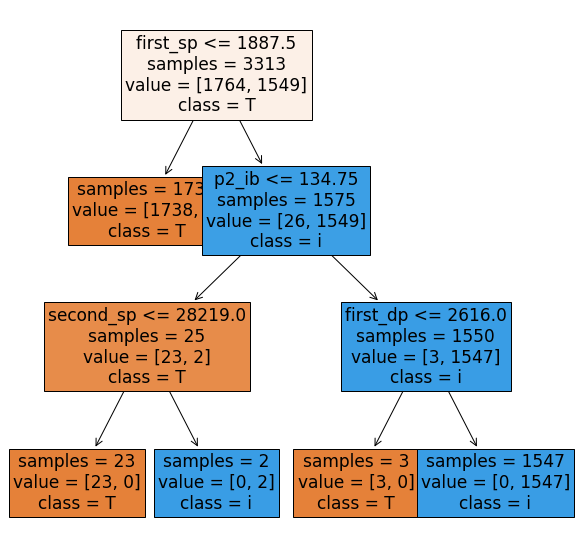

In [16]:
print(colored('Grafico el modelo', attrs=['bold']))
fig, ax = plt.subplots(figsize = (10,10))

print(colored(f'Profundidad del árbol: {model.get_depth()}', attrs=['bold']))
print(colored(f'Número de nodos terminales: {model.get_n_leaves()}', attrs=['bold']))


plot_tree(
    decision_tree = model,
    feature_names = X_train.columns.tolist(),
    class_names   = 'Tipo de trafico minero',
    filled        = True,
    impurity      = False,
    fontsize      = 17,
    ax            = ax
)

In [17]:
print(colored('Realizo la predicción del modelo con la porción de prueba', attrs=['bold']))
y_pred = model.predict(X_test)
y_pred

Realizo la predicción del modelo con la porción de prueba


array([1, 0, 1, ..., 0, 1, 1], dtype=uint8)

In [18]:
len(y_pred[y_pred == 0])

737

In [19]:
len(y_pred[y_pred == 1])

683

### Métricas y matriz de confusión

Matriz de confusión


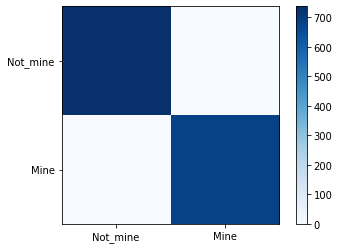

In [20]:
churm = matriz_confusion(y_test, y_pred, plt.cm.Blues)

In [21]:
pd.DataFrame(churm)

,0,1
0,737,0
1,0,683


In [22]:
metricas(y_test, y_pred, churm)

Exactitud:  1.0
Kappa:  1.0
Predicciones de los registros mineros
Precisión:  1.0
Recall:  1.0
Especificidad :  1.0
F1-score      :  1.0
Predicciones de los registros no mineros
Precisión:  1.0
Recall:  1.0
Especificidad :  1.0
F1-score      :  1.0


# Experimento 1

In [23]:
print(colored('Importo el conjunto de datos no puros', attrs=['bold']))
dataB = pd.read_csv('./data_no_identificada.csv')
dataB.columns

Importo el conjunto de datos no puros


Index(['index', 'Name', 'Netflows', 'First_Protocol', 'Second_Protocol',
       'Third_Protocol', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'Type', 'Cryptocurrency'],
      dtype='object')

In [24]:
dataB.shape

(39554, 33)

In [25]:
print(colored('Valores faltantes del conjunto no puro', attrs=['bold']))
dataB.isnull().sum()

Valores faltantes del conjunto no puro


index                  0
Name                   0
Netflows               0
First_Protocol         0
Second_Protocol     6133
Third_Protocol     18674
p1_d                   0
p2_d                   0
p3_d                   0
duration               0
max_d                  0
min_d                  0
#packets               0
Avg_bps                0
Avg_pps                0
Avg_bpp                0
#Bytes                 0
#sp                    0
#dp                    0
first_sp               0
second_sp           7498
third_sp           10993
first_dp               0
second_dp           1708
third_dp            7103
p1_ip                  0
p2_ip                  0
p3_ip                  0
p1_ib                  0
p2_ib                  0
p3_ib                  0
Type                   0
Cryptocurrency         0
dtype: int64

In [26]:
print(colored('Elimino valores faltantes del conjunto de datos no puros, ya que estamos poniendo a prueba nuestro primer modelo, con datos tomados de ambientes no controlados, con la finalidad de observar como se comporta.', attrs=['bold']))

dataB = dataB.dropna()

Elimino valores faltantes del conjunto de datos no puros, ya que estamos poniendo a prueba nuestro primer modelo, con datos tomados de ambientes no controlados, con la finalidad de observar como se comporta.


In [27]:
dataC = dataB

In [28]:
dataB.shape

(19640, 33)

In [29]:
X = dataB[best_feature_sel]
y = dataB['Type'].replace({'mine':1,'not_mine':0})

In [30]:
y_pred = model.predict(X)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

Matriz de confusión


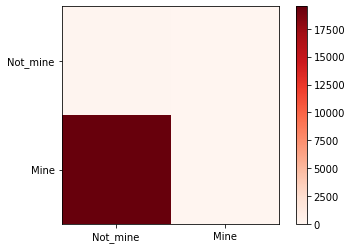

In [31]:
churm = matriz_confusion(y, y_pred, plt.cm.Reds)

In [32]:
pd.DataFrame(churm)

,0,1
0,129,0
1,19502,9


In [33]:
metricas(y, y_pred, churm)

Exactitud:  0.007026476578411405
Kappa:  6.06232125788253e-06
Predicciones de los registros mineros
Precisión:  1.0
Recall:  0.0004612782532930142
Especificidad :  0.0004612782532930142
F1-score      :  0.0009221311475409835
Predicciones de los registros no mineros
Precisión:  0.006571239366308389
Recall:  1.0
Especificidad :  1.0
F1-score      :  0.01305668016194332


# Experimento 2

In [34]:
print(colored('Caracteristicas del conjunto de datos puro', attrs=['bold']))
print(best_feature_sel)

Caracteristicas del conjunto de datos puro
['#dp', '#sp', 'Avg_bpp', 'first_dp', 'first_sp', 'min_d', 'p1_d', 'p1_ip', 'p2_d', 'p2_ib', 'p2_ip', 'p3_ib', 'second_dp', 'second_sp']


In [35]:
print(colored('Caracteristicas del conjunto de datos no puro', attrs=['bold']))
best_feature_noPure = ['#Bytes', '#dp', '#packets', '#sp', 'Avg_bpp', 'Avg_bps',
       'Avg_pps', 'duration', 'first_dp', 'p2_d', 'p2_ib', 'p3_d',
       'p3_ip', 'second_dp', 'second_sp', 'third_dp', 'third_sp']
print(best_feature_noPure)

Caracteristicas del conjunto de datos no puro
['#Bytes', '#dp', '#packets', '#sp', 'Avg_bpp', 'Avg_bps', 'Avg_pps', 'duration', 'first_dp', 'p2_d', 'p2_ib', 'p3_d', 'p3_ip', 'second_dp', 'second_sp', 'third_dp', 'third_sp']


In [36]:
print(colored('Combino las caracteristicas', attrs=['bold']))
bestFeature = np.concatenate([best_feature_sel,best_feature_noPure])
bestFeature = np.unique(bestFeature)
bestFeature

Combino las caracteristicas


array(['#Bytes', '#dp', '#packets', '#sp', 'Avg_bpp', 'Avg_bps',
       'Avg_pps', 'duration', 'first_dp', 'first_sp', 'min_d', 'p1_d',
       'p1_ip', 'p2_d', 'p2_ib', 'p2_ip', 'p3_d', 'p3_ib', 'p3_ip',
       'second_dp', 'second_sp', 'third_dp', 'third_sp'], dtype='<U9')

### Preprocesamiento

In [37]:
dataB = pd.read_csv('./data_no_identificada.csv').drop(['index','Name','Second_Protocol', 'Third_Protocol'], axis = 1)
dataB.columns

Index(['Netflows', 'First_Protocol', 'p1_d', 'p2_d', 'p3_d', 'duration',
       'max_d', 'min_d', '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes',
       '#sp', '#dp', 'first_sp', 'second_sp', 'third_sp', 'first_dp',
       'second_dp', 'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib',
       'p3_ib', 'Type', 'Cryptocurrency'],
      dtype='object')

### Imputar valores

In [38]:
punter = pd.concat([dataB['second_sp'],dataB['third_sp'],dataB['second_dp'],dataB['third_dp']], axis = 1)
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
values = imputer.fit_transform(punter)

In [39]:
values = pd.DataFrame(values, columns = punter.columns)
dataB['second_sp'] = values['second_sp']
dataB['third_sp'] = values['third_sp']
dataB['second_dp'] = values['second_dp']
dataB['third_dp'] = values['third_dp']

### OneHotEncoder

In [40]:
data_categoric = dataB.select_dtypes(['object'])
one_hot =  OneHotEncoder()
one_hot.fit_transform(data_categoric)
dataDummy = pd.get_dummies(data_categoric)
dataB = dataB.drop(data_categoric.columns, axis = 1)
dataB = pd.concat([dataB,dataDummy],axis = 1)
dataB.head(1)

,Netflows,p1_d,p2_d,p3_d,duration,max_d,min_d,#packets,Avg_bps,Avg_pps,...,p2_ib,p3_ib,First_Protocol_ICMP,First_Protocol_ICMP6,First_Protocol_TCP,First_Protocol_UDP,Type_mine,Type_not_mine,Cryptocurrency_Does not have,Cryptocurrency_Unidentified
0,17,0.0,3.001,360.024,2790.015,569.693,0.0,95,160,0,...,500.0,700.0,0,0,0,1,1,0,0,1


In [41]:
print(colored('Aplico una tecnica de submuestreo para equilibrar las clases del conjunto de datos no puros,  con la finalidad de balanciar el conjunto de datos', attrs=['bold']))
data_N_Mineros = dataB[dataB.Type_mine == 1]
data_N_Mineros = data_N_NoMineros = dataB.sample(n=dataA[dataA.Type_mine == 1].shape[0])

Aplico una tecnica de submuestreo para equilibrar las clases del conjunto de datos no puros,  con la finalidad de balanciar el conjunto de datos


In [75]:
indes_porcion_minera = data_N_Mineros.index
indes_porcion_minera

Int64Index([18784, 13262, 10975, 38580,  2354, 21993, 16271, 16869,  3308,
            39520,
            ...
            26914, 32465, 16909,  4061, 25807, 16572, 32639, 29159,  5408,
            23837],
           dtype='int64', length=2232)

In [42]:
print(colored('Ambos conjuntos de datos, tienen los mismos registros benignos, se podria conciderar como una tecnica de sobremuestreo', attrs=['bold']))
nueva_dataB = pd.concat([data_N_Mineros, dataB[dataB.Type_mine == 0]], axis = 0)

Ambos conjuntos de datos, tienen los mismos registros benignos, se podria conciderar como una tecnica de sobremuestreo


In [43]:
print(colored('Ambos conjuntos de datos (puros y no puro), se podrian conciderar balanceados ', attrs=['bold']))

nueva_dataB.shape, dataA.shape

Ambos conjuntos de datos (puros y no puro), se podrian conciderar balanceados 


((4733, 34), (4733, 38))

In [44]:
print(colored('Unimos los conjuntos de datos y aplicamos aleatoriedad en la posición de los registros', attrs=['bold']))


Unimos los conjuntos de datos y aplicamos aleatoriedad en la posición de los registros


In [45]:
data_final = pd.concat([nueva_dataB, dataA], axis = 0)
data_final.shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(9466, 39)

In [46]:
print(colored('Aleatoriedad', attrs=['bold']))
data_final = data_final.reset_index()
indices = list(data_final.index)
random.shuffle(indices)
data_final = data_final.reindex(indices)
data_final.head()

Aleatoriedad


,index,#Bytes,#dp,#packets,#sp,Avg_bpp,Avg_bps,Avg_pps,Cryptocurrency_Bitcash,Cryptocurrency_Bitcoin,...,p2_d,p2_ib,p2_ip,p3_d,p3_ib,p3_ip,second_dp,second_sp,third_dp,third_sp
625,1691,490,3,11,2,44,13,0,NaN,NaN,...,0.0000,32.0,1.0,0.00000,38.50,1.00,5353.0,5353.0,34304.0,45560.0
146,19478,8075,6,69,5,117,238,0,NaN,NaN,...,0.0000,103.5,1.0,17.28450,334.00,2.25,17500.0,17500.0,1281.0,49604.0
3198,15480,4601524,30,5382,35,854,135891,19,NaN,NaN,...,1.3375,64.0,2.0,45.06075,128.00,4.00,80.0,80.0,1900.0,49626.0
6658,1925,4605166,39,5210,44,883,137854,19,0.0,0.0,...,1.7365,67.0,2.0,45.54675,253.25,4.00,443.0,443.0,80.0,80.0
8283,3550,29286,2,65,2,450,411,0,1.0,0.0,...,568.7805,14643.0,32.5,568.78075,21582.00,32.75,49875.0,49875.0,443.0,123.0


In [47]:
data_final.isnull().sum()

index                              0
#Bytes                             0
#dp                                0
#packets                           0
#sp                                0
Avg_bpp                            0
Avg_bps                            0
Avg_pps                            0
Cryptocurrency_Bitcash          4733
Cryptocurrency_Bitcoin          4733
Cryptocurrency_Does not have       0
Cryptocurrency_Etherium         4733
Cryptocurrency_Litecoin         4733
Cryptocurrency_Monero           4733
Cryptocurrency_Unidentified     4733
First_Protocol_ICMP                0
First_Protocol_ICMP6               0
First_Protocol_TCP                 0
First_Protocol_UDP                 0
Netflows                           0
Type_mine                          0
Type_not_mine                      0
duration                           0
first_dp                           0
first_sp                           0
max_d                              0
min_d                              0
p

### Modelo

In [48]:
X = data_final[bestFeature]
y = data_final['Type_mine']

In [49]:
model = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=5,      
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=None,  
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None)

In [50]:
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
scores = cross_validate(model, X, y, scoring=scoring, cv=10, return_train_score=False)

for key in scores:
    score = scores[key]
    print("%s: %0.2f (+/- %0.2f)" % (key, score.mean(), score.std() * 2))


fit_time: 0.24 (+/- 0.12)
score_time: 0.02 (+/- 0.00)
test_accuracy: 1.00 (+/- 0.00)
test_precision_weighted: 1.00 (+/- 0.00)
test_recall_weighted: 1.00 (+/- 0.00)
test_f1_weighted: 1.00 (+/- 0.00)


In [51]:
K_fold = KFold(n_splits = 10)

In [52]:
resultados_train = []
resultados_test = []
predicciones = []
scores = []
modelos = []


for result in K_fold.split(X):
    resultados_train.append(result[0])
    resultados_test.append(result[1])
    X_train = X.iloc[result[0]]
    X_test =  X.iloc[result[1]]
    y_train =  y.iloc[result[0]]
    y_test =  y.iloc[result[1]]
    model = model.fit(X_train,y_train)
    modelos.append(model)
    predic = model.predict(X_test)
    predicciones.append(predic)
    scores.append(model.score(X_test, y_test))

In [53]:
scores

[0.9989440337909187,
 0.9978880675818373,
 0.996832101372756,
 0.9989440337909187,
 0.9957761351636748,
 0.9978880675818373,
 0.9978858350951374,
 1.0,
 0.9989429175475687,
 0.9947145877378436]

Matriz de confusión


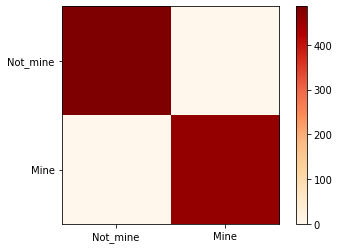

In [54]:
churm = matriz_confusion(y.iloc[resultados_test[0]], predicciones[0], plt.cm.OrRd)

In [55]:
pd.DataFrame(churm)

,0,1
0,486,0
1,1,460


In [56]:
metricas(y.iloc[resultados_test[0]], predicciones[0], churm)

Exactitud:  0.9989440337909187
Kappa:  0.9978864767992287
Predicciones de los registros mineros
Precisión:  1.0
Recall:  0.9978308026030369
Especificidad :  0.9978308026030369
F1-score      :  0.998914223669924
Predicciones de los registros no mineros
Precisión:  0.997946611909651
Recall:  1.0
Especificidad :  1.0
F1-score      :  0.998972250770812


### Prueba final

In [183]:
indes_porcion_minera

Int64Index([18784, 13262, 10975, 38580,  2354, 21993, 16271, 16869,  3308,
            39520,
            ...
            26914, 32465, 16909,  4061, 25807, 16572, 32639, 29159,  5408,
            23837],
           dtype='int64', length=2232)

In [191]:
dataC.shape

(19640, 33)

In [190]:
dataRestanteC.shape

(18520, 33)

In [189]:
dataRestanteC = dataC[~dataC['index'].isin(indes_porcion_minera)]

In [173]:
X_p = dataRestanteC[bestFeature]
y_p = dataRestanteC['Type'].replace({'mine':1,'not_mine':0})

In [174]:
y_pred_proba = modelos[0].predict(X_p)

Matriz de confusión


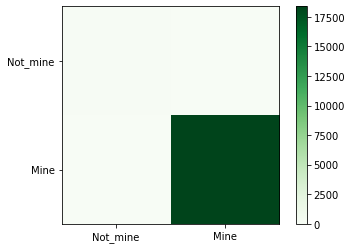

In [175]:
churm = matriz_confusion(y_p, y_pred_proba, plt.cm.Greens)

In [176]:
pd.DataFrame(churm)

,0,1
0,119,0
1,24,18377


In [177]:
dataC[dataC.Type=='mine'].shape

(19511, 33)

In [178]:
dataC[dataC.Type=='not_mine'].shape

(129, 33)

In [179]:
metricas(y_p, y_pred_proba, churm)

Exactitud:  0.9987041036717063
Kappa:  0.9077498969533474
Predicciones de los registros mineros
Precisión:  1.0
Recall:  0.9986957230585294
Especificidad :  0.9986957230585294
F1-score      :  0.9993474359671543
Predicciones de los registros no mineros
Precisión:  0.8321678321678322
Recall:  1.0
Especificidad :  1.0
F1-score      :  0.9083969465648856


In [64]:
y_pred_proba = model.predict_proba(X_test)

In [65]:
lr_probs = y_pred_proba[:,1]

In [66]:
ns_probs = [0 for _ in range(len(y_test))]

In [67]:
ns_auc = metrics.roc_auc_score(y_test, ns_probs)
ns_auc

0.5

In [68]:
lr_auc = metrics.roc_auc_score(y_test, lr_probs)
lr_auc

0.9973906515683223

In [69]:
#Sumo los scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Treeb: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
Treeb: ROC AUC=0.997


In [70]:
ns_fpr, ns_tpr, thresholds  = metrics.roc_curve(y_test,ns_probs)
lr_fpr, lr_tpr, thresholds = metrics.roc_curve(y_test, lr_probs)

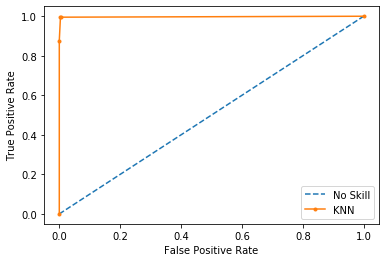

In [71]:
#Plot la roc curva para el modelo
plt.plot(ns_fpr,ns_tpr,linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Holdaunt 70% pero debo hacer una validadci{on cruzada en este conjunto de entrenamiento (Puros), de este cruz validation saldra un modelo, y lo testeo con el 30%, con este porcentaje, le saco las metricas